# CS4487 - Course Project
Due date: Nov 27, 2015 11:59pm HKT

## Goal
You can select your course project as _one_ of the following Kaggle competitions:
  1. [What's cooking?](https://www.kaggle.com/c/whats-cooking) - cooking ingredients to classify the type of cuisine.
  2. [Trip type classification](https://www.kaggle.com/c/walmart-recruiting-trip-type-classification) - from a shopping list, predict the what type of shopping trip the customer is on (e.g., weekly groceries, clothes shopping).

## Groups
Group projects with at most 2 students are allowed.  To sign up for a group, go to Canvas and under "People", join one of the existing "Project Groups".  _For group projects, the project report must state the percentage contribution from each project member._

## Methodology
You are free to choose the methodology to solve the task.  In machine learning, it is important to use domain knowledge to help solve the problem.  Hence, instead of blindly applying the algorithms to the data you need to think about how to represent the data in a way that makes sense for the algorithm to solve the task. 


## Evaluation on Kaggle

Besides evaluating on the validation set, you need to submit your test results to Kaggle for evaluation.

## Project Presentation

Each project group needs to give a presentation at the end of the semester.  The presentation time is 10 minutes.  You _must_ give a presentation.

## What to hand in
You need to turn in the following things:

1. This ipynb file with your source code and documentation.
2. Your final submission file to Kaggle.
3. Presentation slides.

Files should be uploaded to "Course Project" on Canvas.


## Grading
The marks of the assignment are distributed as follows:
- 50% - Results using various feature representations, dimensionality reduction methods, classifiers, etc.
- 20% - Trying out feature representations (e.g. adding additional features, combining features from different sources) or methods not used in the tutorials.
- 15% - Quality of the written report.  More points for insightful observations and analysis.
- 15% - Project presentation.
<hr>

# Competition: What's Cooking

## Imports

In [17]:
# Provided imports
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats
import IPython.utils.warn as warn
random.seed(100)
import json
import csv

# Additional imports
from time import time
from time import sleep
import re
import pandas as pd
import nltk     # Packages & Corpora need to be downloaded using nltk.download()
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from ipyparallel import Client
from ipyparallel import require
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import chi2, SelectPercentile, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
import xgboost as xgb

In [12]:
# Packages & Corpora need to be downloaded using the following statement.
# The NLTK Downloader will open in a separate window.
nltk.download()

showing info http://www.nltk.org/nltk_data/


True

In [4]:
# Load the IPython Parallel Client
client = Client()
print client.ids      # client process ids

# get the load-balanced scheduler
lview = client.load_balanced_view()

[0, 1, 2, 3, 4, 5, 6]


In [6]:
%%px 
# load libraries on IPython engine cluster
from numpy import *
from sklearn import *
import re
import pandas as pd
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2, SelectPercentile, SelectFromModel
import xgboost as xgb

## Provided function to create submission files

In [7]:
# write a kaggle submission file for "whats cooking"
def write_csv_kaggle_cooking(fname, ids, target):
    # header
    tmp = [['id', 'cuisine']]
    
    for i in range(len(ids)):
        # add a row (id and class prediction)
        tmp.append([ids[i], target[i]])
        
    # write CSV file
    f = open(fname, 'wb')
    writer = csv.writer(f)
    writer.writerows(tmp)
    f.close()

## Load the data

In [3]:
kaggle_train = pd.read_json("whats_cooking/train.json")
kaggle_test = pd.read_json("whats_cooking/test.json")
print len(kaggle_train)
print len(kaggle_test)

39774
9944


In [4]:
# Sample
print kaggle_train['ingredients'][0]
print kaggle_train['cuisine'][0]

[u'romaine lettuce', u'black olives', u'grape tomatoes', u'garlic', u'pepper', u'purple onion', u'seasoning', u'garbanzo beans', u'feta cheese crumbles']
greek


In [10]:
# Print all class (cuisine) labels
label_names = unique(kaggle_train['cuisine'])
print ("Number of classes: %d" % len(label_names))
print label_names

Number of classes: 20
[u'brazilian' u'british' u'cajun_creole' u'chinese' u'filipino' u'french'
 u'greek' u'indian' u'irish' u'italian' u'jamaican' u'japanese' u'korean'
 u'mexican' u'moroccan' u'russian' u'southern_us' u'spanish' u'thai'
 u'vietnamese']


# Preprocessing


Steps:
1. Clean the data by removing numbers and symbols.
2. Lemmatize individual words in the ingredient lists.
    - Lemmatization reduces the words to linguistically valid lemmas with the use of a vocabulary and morphological analysis of words. Example: "having" => "have"  
    - I have written the lemmatize_list function to be able to take POS (Part-of-Speech) for individual words into consideration during the lemmatization process.
3. Convert the ingredient lists into strings where ingredients are delimited by commas.

### Helper Functions

In [6]:
# This function
def clean_list(inputList):
    cleaned = []
    for item in inputList:
        cleaned.append(re.sub('[^a-z A-Z]','',item))
    return cleaned

# This function is used to convert a Treebank POS (Part-of-Speech) tag
# to a Wordnet POS tag for use with the WordNetLemmatizer
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

@require(get_wordnet_pos)
def lemmatize_list(tokens):
    lemmatized = []
    # Tag POS (Part-of-Speech) for each token
    tokens_w_tags = nltk.pos_tag(tokens)
    # Lemmatize according to POS tag
    for item in tokens_w_tags:
        wn_pos = get_wordnet_pos(item[1])
        if wn_pos != '':
            lemmatized.append(WordNetLemmatizer().lemmatize(item[0], pos=wn_pos))
        else:
            lemmatized.append(WordNetLemmatizer().lemmatize(item[0]))
    return lemmatized

def list_to_str(inputList):
    s = ""
    for item in inputList:
        s = s + item + ", "
    return s.strip().rstrip(',')

@require(clean_list, lemmatize_list, list_to_str)
def preprocess(data):
    cleanData = data.apply(lambda x: clean_list(x))
    lemmatizedData = cleanData.apply(lambda x: lemmatize_list(x))
    dataText = lemmatizedData.apply(lambda x: list_to_str(x))
    return dataText

### Procedure

In [8]:
# Split the data for parallelization
ppTrainData = []
i = 0
while True:
    ppTrainData.append(kaggle_train['ingredients'][i:(i+100)])
    i += 100
    if i > len(kaggle_train):
        break
print len(ppTrainData)

398


In [9]:
# Preprocess the data on the IPython clusters
client.block = False
lview.block = False
t0 = time()
ppTrainOutput = lview.map(preprocess, ppTrainData)
while not ppTrainOutput.ready():
    sleep(300)              # wait 5 minutes
    print ppTrainOutput.progress # prints how many jobs have finished
print("Pre-processing completed in %0.1f minutes" % ((time() - t0)/60))

7
14
21
28
36
49
56
63
70
78
91
98
105
112
120
133
140
147
154
161
175
182
189
196
204
216
224
231
238
246
258
266
273
280
288
300
308
315
322
330
342
350
357
364
373
384
392
398
Pre-processing completed in 240.0 minutes


In [29]:
# Combine preprocessed results
pp_kaggle_trainX = pd.Series()
for result in ppTrainOutput:
    pp_kaggle_trainX = pp_kaggle_trainX.append(result)
print len(pp_kaggle_trainX)

39774


In [32]:
# Sanity check
print pp_kaggle_trainX.equals(pp_kaggle_trainX.sort_index())

True


In [52]:
# Save data to csv for later use
pp_kaggle_trainX.to_csv('my_data_and_models/pp_kaggle_trainX.csv')

In [57]:
# Sanity Check
# test = pd.Series.from_csv('my_data_and_models/pp_kaggle_trainX.csv')
# print test.equals(pp_kaggle_trainX)

True


In [8]:
# Store labels in a new variable to facilitate clean-up of unused variables (using the del statement)
kaggle_trainY = kaggle_train['cuisine']
# kaggle_trainY.to_csv('my_data_and_models/kaggle_trainY.csv')
print len(kaggle_trainY)

39774


In [102]:
# Repeat process for Kaggle test data
ppTestData = []
i = 0
while True:
    ppTestData.append(kaggle_test['ingredients'][i:(i+100)])
    i += 100
    if i > len(kaggle_test):
        break
print len(ppTestData)

100


In [105]:
client.block = False
lview.block = False
t0 = time()
ppTestOutput = lview.map(preprocess, ppTestData)
while not ppTestOutput.ready():
    sleep(300)              # wait 5 minutes
    print ppTestOutput.progress # prints how many jobs have finished
print("Pre-processing completed in %0.1f minutes" % ((time() - t0)/60))

7
14
21
28
35
49
56
63
70
77
91
99
100
Pre-processing completed in 65.0 minutes


In [106]:
# Combine preprocessed results
pp_kaggle_testX = pd.Series()
for result in ppTestOutput:
    pp_kaggle_testX = pp_kaggle_testX.append(result)
print len(pp_kaggle_testX)
# Sanity check
print pp_kaggle_testX.equals(pp_kaggle_testX.sort_index())

9944
True


In [107]:
# Save data to csv for later use
pp_kaggle_testX.to_csv('my_data_and_models/pp_kaggle_testX.csv')

#### Retrieval of preprocessed data from csv files

In [4]:
pp_kaggle_trainX = pd.Series.from_csv('my_data_and_models/pp_kaggle_trainX.csv')
kaggle_trainY = kaggle_train['cuisine']
pp_kaggle_testX = pd.Series.from_csv('my_data_and_models/pp_kaggle_testX.csv')

print len(pp_kaggle_trainX)
print len(kaggle_trainY)
print len(pp_kaggle_testX)

39774
39774
9944


# Simple Data Exploration

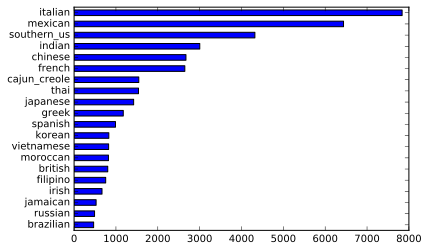

In [5]:
# Find & plot label (cuisine) counts
label_counts = Counter(kaggle_trainY)
label_fig = pd.DataFrame(label_counts, index=[0]).transpose()[0].sort_values(ascending=False, inplace=False).plot(kind='barh')
label_fig.invert_yaxis()

In [31]:
# Find ingredient counts
recipe_ingredients = [Counter(recipe.split(', ')) for recipe in pp_kaggle_trainX]
ingredient_counts = sum(recipe_ingredients)

In [37]:
print ("Number of ingredients: %d" % len(ingredient_counts))

Number of ingredients: 6801


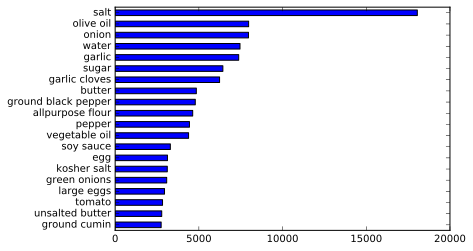

In [41]:
# Plot counts for top 20 ingredients
ingredient_fig = pd.DataFrame(ingredient_counts, index=[0]).transpose()[0] \
    .sort_values(ascending=False, inplace=False)[:20].plot(kind='barh')
ingredient_fig.invert_yaxis()

# Create a train (development) & test (evaluation) split

On examining the data it is observed that the distribution of the classes is highly imbalanced. Therefore, a standard train-test split may not be suitable for validation. We use StratifiedShuffleSplit instead, which maintains the percentages of samples for each class in the split sets. 

This approach seems to prove fruitful, as it is later observed that there is a high degree of correlation between the prediction accuracies on the evaluation set and on the Kaggle test set.

In [12]:
sss = StratifiedShuffleSplit(kaggle_trainY, n_iter=1, test_size=0.2, random_state=4487)
for dev_index, eval_index in sss:
    devX, evalX = pp_kaggle_trainX[dev_index], pp_kaggle_trainX[eval_index]
    devY, evalY = kaggle_trainY[dev_index], kaggle_trainY[eval_index]
print len(devX)
print len(evalX)

31818
7956


# Feature Extraction

### Helper Functions

In [13]:
def split_by_ingredient(text):
    return text.split(',')

def plot_confusion_matrix(testY, predY, labels, title='Confusion matrix', cmap=plt.cm.Greys):
    cm = confusion_matrix(testY, predY, labels)
    # Normalize the confusion matrix by row (i.e by the number of samples in each class)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, newaxis]
    set_printoptions(precision=2)
    plt.figure(figsize=(8,8))
    # plot_confusion_matrix(cm_normalized)
    plt.imshow(cm_normalized, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = arange(len(label_names))
    plt.xticks(tick_marks, label_names, rotation=45)
    plt.yticks(tick_marks, label_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Procedure

### Bag of Ingredients (BoI)
Using a custom tokenizer function (split_by_ingredient), the strings passed to a CountVectorizer are split at the commas. This allows us to model ingredient presence in each recipe sample, when paired with setting the parameter binary=True. 

In [14]:
ingred_vect = CountVectorizer(tokenizer=split_by_ingredient, binary=True, lowercase=True)
ingred_devX = ingred_vect.fit_transform(devX)
ingred_evalX = ingred_vect.transform(evalX)
print len(ingred_vect.vocabulary_)

8660


### Bag of Words (BoW)

Here we use default tokenization and use 1-grams with a TfidfVectorizer to generate a standard Bag of Words representation. 
This feature representation is found to produce better results, perhaps because it allows the classifiers to make better sense of the individual words in the ingredient names.

In [15]:
tfidf_vect = TfidfVectorizer(ngram_range=(1, 1), use_idf=True, stop_words='english', lowercase=True)
tfidf_devX = tfidf_vect.fit_transform(devX)
tfidf_evalX = tfidf_vect.transform(evalX)
print len(tfidf_vect.vocabulary_)

2926


# Classification

## Approach 1: Single Classifier
Here we simply test the effectiveness of various base classifiers.

Training completed in 5.35 seconds
0.851122006411
0.762569130216


C:\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


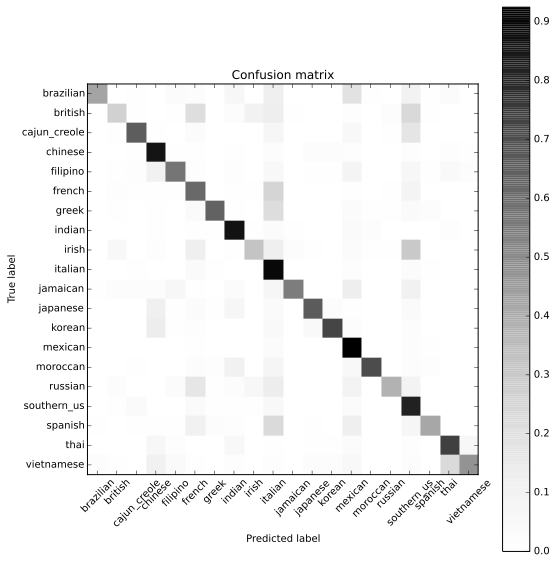

In [18]:
# Logistic Regression
t0 = time()
clf = linear_model.LogisticRegression(C=0.5)
clf.fit(ingred_devX, devY)
print("Training completed in %0.2f seconds" % (time() - t0))
predY = clf.predict(ingred_evalX)
print(clf.score(ingred_devX,devY))
print(clf.score(ingred_evalX,evalY))
plot_confusion_matrix(evalY, predY, labels=label_names)

Training completed in 8.69 seconds
0.83723049846
0.78142282554


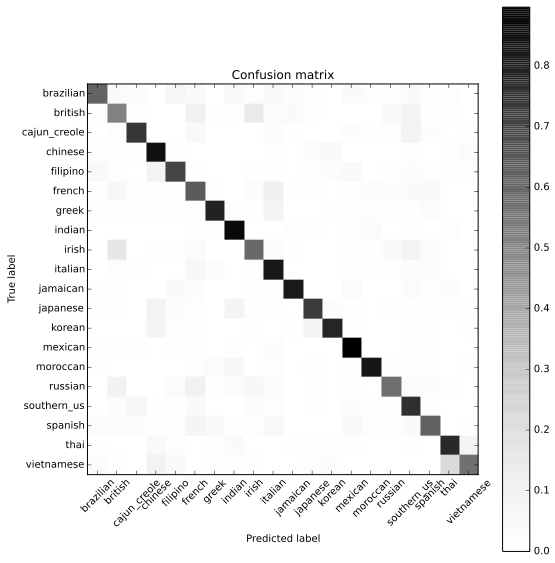

In [20]:
# Logistic Regression with balanced class weights
t0 = time()
lr_clf = linear_model.LogisticRegression(C=3.7, class_weight='balanced')
lr_clf.fit(tfidf_devX, devY)
print("Training completed in %0.2f seconds" % (time() - t0))
predY = lr_clf.predict(tfidf_evalX)
print(lr_clf.score(tfidf_devX,devY))
print(lr_clf.score(tfidf_evalX,evalY))
plot_confusion_matrix(evalY, predY, labels=label_names)

Training completed in 1.14 seconds
0.852096297693
0.790975364505


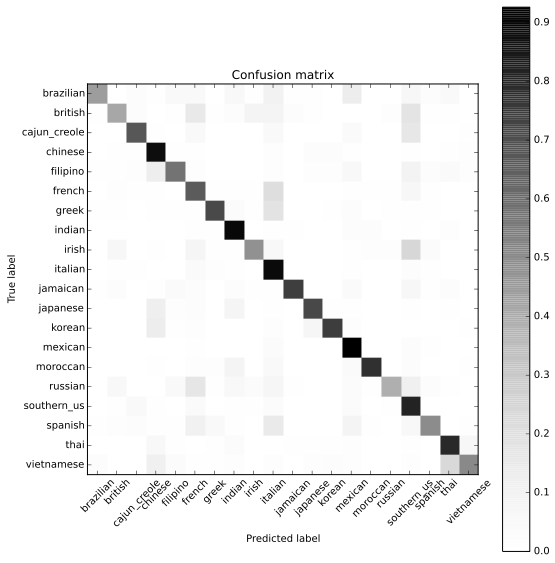

In [19]:
# LinearSVC
t0 = time()
lsvc_clf = svm.LinearSVC(C=0.5, dual=True)
lsvc_clf.fit(tfidf_devX, devY)
print("Training completed in %0.2f seconds" % (time() - t0))
predY = lsvc_clf.predict(tfidf_evalX)
print(lsvc_clf.score(tfidf_devX,devY))
print(lsvc_clf.score(tfidf_evalX,evalY))
plot_confusion_matrix(evalY, predY, labels=label_names)

Training completed in 1.31 seconds
0.838299075995
0.780417295123


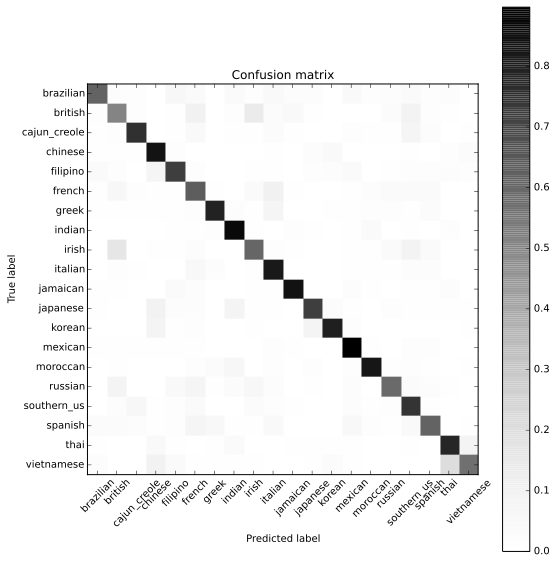

In [21]:
# LinearSVC with balanced class weights
t0 = time()
lsvc_clf = svm.LinearSVC(C=0.35, dual=True, class_weight='balanced')
lsvc_clf.fit(tfidf_devX, devY)
print("Training completed in %0.2f seconds" % (time() - t0))
predY = lsvc_clf.predict(tfidf_evalX)
print(lsvc_clf.score(tfidf_devX,devY))
print(lsvc_clf.score(tfidf_evalX,evalY))
plot_confusion_matrix(evalY, predY, labels=label_names)

Training completed in 5.90 seconds
0.993557106041
0.679612870789


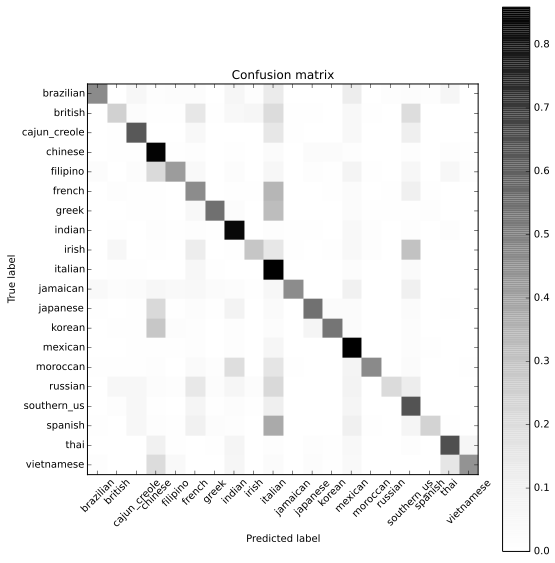

In [22]:
# Random Forests
t0 = time()
rf_gini_clf = ensemble.RandomForestClassifier(n_estimators = 10, criterion = 'gini', class_weight='balanced')
rf_gini_clf.fit(tfidf_devX, devY)
print("Training completed in %0.2f seconds" % (time() - t0))
predY = rf_gini_clf.predict(tfidf_evalX)
print(rf_gini_clf.score(tfidf_devX,devY))
print(rf_gini_clf.score(tfidf_evalX,evalY))
plot_confusion_matrix(evalY, predY, labels=label_names)

Training completed in 7.40 seconds
0.999622854988
0.70173453997


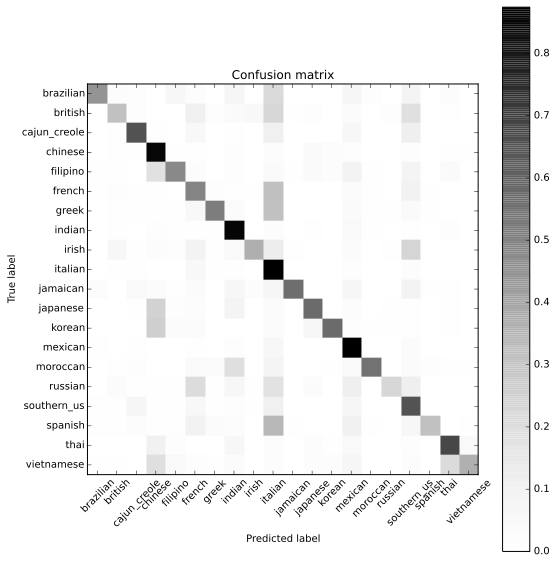

In [23]:
# Extra Trees Classifier
t0 = time()
clf = ensemble.ExtraTreesClassifier(n_estimators = 10, criterion = 'gini', class_weight='balanced')
clf.fit(tfidf_devX, devY)
print("Training completed in %0.2f seconds" % (time() - t0))
predY = clf.predict(tfidf_evalX)
print(clf.score(tfidf_devX,devY))
print(clf.score(tfidf_evalX,evalY))
plot_confusion_matrix(evalY, predY, labels=label_names)

Training completed in 1.23 seconds
0.81108177761
0.710030165913


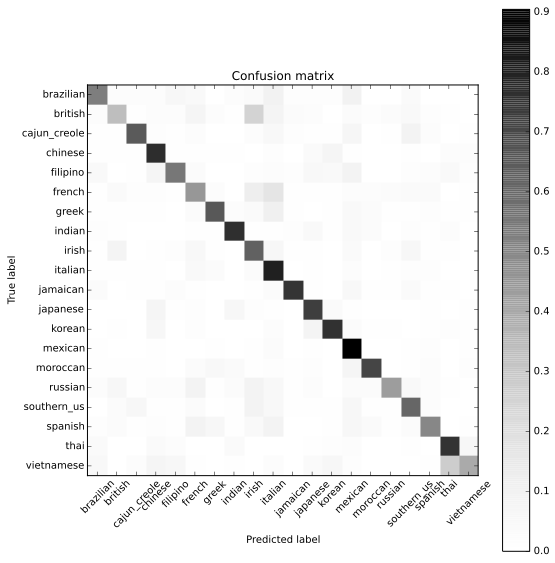

In [24]:
# Perceptron
t0 = time()
p_clf = linear_model.Perceptron(alpha=0.0001, n_iter=15, class_weight='balanced', random_state=4487)
p_clf.fit(tfidf_devX, devY)
print("Training completed in %0.2f seconds" % (time() - t0))
predY = p_clf.predict(tfidf_evalX)
print(p_clf.score(tfidf_devX,devY))
print(p_clf.score(tfidf_evalX,evalY))
plot_confusion_matrix(evalY, predY, labels=label_names)

Training completed in 0.28 seconds
0.784524482997
0.739190548014


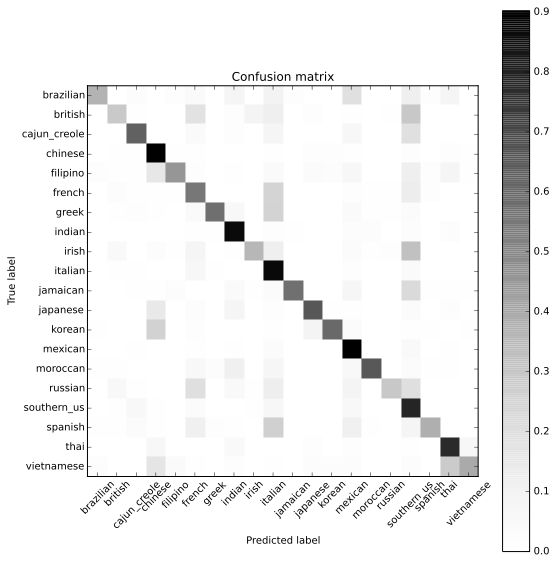

In [25]:
# Multinomial Naive Bayes
t0 = time()
# mnb_clf = naive_bayes.BernoulliNB(alpha=1)
mnb_clf = naive_bayes.MultinomialNB(alpha=0.01)
mnb_clf.fit(tfidf_devX, devY)
print("Training completed in %0.2f seconds" % (time() - t0))
predY = mnb_clf.predict(tfidf_evalX)
print(mnb_clf.score(tfidf_devX,devY))
print(mnb_clf.score(tfidf_evalX,evalY))
plot_confusion_matrix(evalY, predY, labels=label_names)

Training completed in 22.71 seconds
0.514111509209
0.508044243338


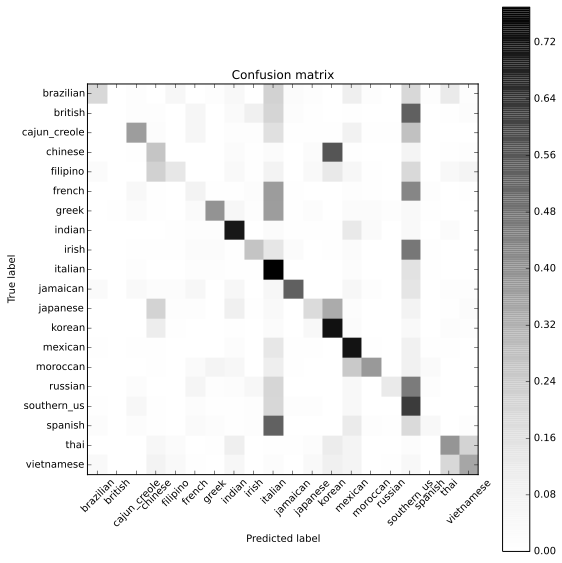

In [26]:
# AdaBoost Classifier
t0 = time()
ab_clf = ensemble.AdaBoostClassifier(n_estimators=100, random_state=4487)
ab_clf.fit(tfidf_devX, devY)
print("Training completed in %0.2f seconds" % (time() - t0))
predY = ab_clf.predict(tfidf_evalX)
print(ab_clf.score(tfidf_devX,devY))
print(ab_clf.score(tfidf_evalX,evalY))
plot_confusion_matrix(evalY, predY, labels=label_names)

Training completed in 43.26 seconds
0.823621849268
0.734539969834


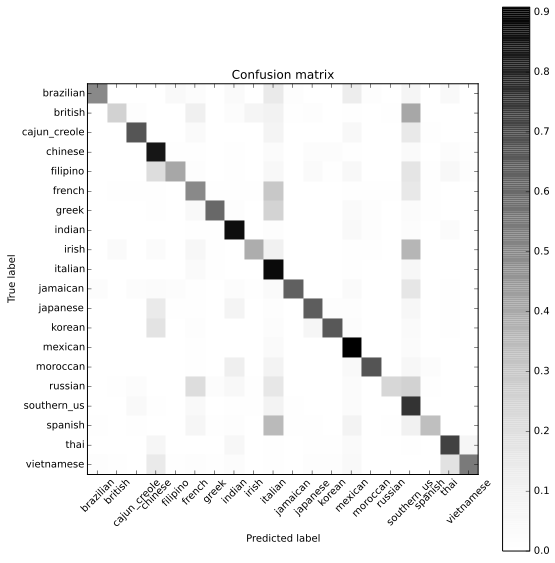

In [27]:
# XGBoost
t0 = time()
clf = xgb.XGBClassifier(n_estimators=50, max_depth=6)
clf.fit(tfidf_devX, devY)
print("Training completed in %0.2f seconds" % (time() - t0))
predY = clf.predict(tfidf_evalX)
print(clf.score(tfidf_devX,devY))
print(clf.score(tfidf_evalX,evalY))
plot_confusion_matrix(evalY, predY, labels=label_names)

In [26]:
# LinearSVC with features selected from Random Forests
t0 = time()
sfm = SelectFromModel(rf_gini_clf, prefit=True)
feat_devX = sfm.transform(tfidf_devX)
feat_evalX = sfm.transform(tfidf_evalX)

lsvc_sfm_clf = svm.LinearSVC(C=1, dual=True)
lsvc_sfm_clf.fit(feat_devX, devY)
print("Training completed in %0.2f seconds" % (time() - t0))
predY = lsvc_sfm_clf.predict(feat_evalX)
print(lsvc_sfm_clf.score(feat_devX,devY))
print(lsvc_sfm_clf.score(feat_evalX,evalY))

Training completed in 1.66 seconds
0.784335910491
0.752388134741


### Observation:
Linear classifiers such as Logistic Regression and LinearSVC perform well with this data set. Balancing the class weights can reduce overall classifier accuracy, but it also seems to reduce the number of false negatives.

## Approach 2: Voting Ensemble
The VotingClassifier makes predictions based on the average predicted probablities (soft voting).
Here, I have assigned higher weights to the linear models because they seem to perform better on this data set.

In [55]:
t0 = time()
ve_clf = ensemble.VotingClassifier(estimators=[
        ('lr', linear_model.LogisticRegression(C=10)), 
        ('lrb', linear_model.LogisticRegression(C=3.7, class_weight='balanced')),
        ('svc', svm.SVC(kernel='linear', C=0.5, probability=True)), 
        ('svcb', svm.SVC(kernel='linear', C=0.5, probability=True, class_weight='balanced')), 
        ('mnb', naive_bayes.MultinomialNB(alpha=0.01)), 
        ('bnb', naive_bayes.BernoulliNB(alpha=1))
        ('adb', ensemble.AdaBoostClassifier(n_estimators=100, random_state=4487)),
        ('rfg', ensemble.RandomForestClassifier(n_estimators = 100, criterion = 'gini', class_weight='balanced')), 
        ('rfe', ensemble.RandomForestClassifier(n_estimators = 100, criterion = 'entropy', class_weight='balanced')),
        ('etg', ensemble.ExtraTreesClassifier(n_estimators=100, criterion='gini', class_weight='balanced')),
        ('ete', ensemble.ExtraTreesClassifier(n_estimators=100, criterion='entropy', class_weight='balanced')),
        ('xgb', xgb.XGBClassifier(n_estimators=100, max_depth=9))
    ], voting='soft', weights=[2,2,2,2,1,1,1,1,1,1,1])
ve_clf.fit(tfidf_devX, devY)
print("Training completed in %0.2f seconds" % (time() - t0))
print(ve_clf.score(tfidf_devX,devY))
print(ve_clf.score(tfidf_evalX,evalY))

Training completed in 1439.40 seconds
0.936513922937
0.797637003519


## Approach 3: Stacked Ensemble
Here the predicted class probablities from several base classifiers (Level 0) are used as meta-features for another classifier which does the final prediction.

UPDATE: The method used here is not true stacked generalization as described by Wolpert in "Stacked Generalization" (1992), since it does not make use of out-of-fold predictions. This method is therefore more susceptible to overfitting, which I was not aware of at the time of working on this assignment.

### Helper Functions

In [13]:
def fit_clf(clf, data, prob=True, weight=1):
    clf.fit(data['trainX'], data['trainY'])
    if (prob == True):
        pred_trainY = clf.predict_proba(data['trainX'])
        pred_testY = clf.predict_proba(data['testX'])
    else:
        pred_trainY = clf.decision_function(data['trainX'])
        pred_testY = clf.decision_function(data['testX'])
    if (weight > 1):
        temp_trainY = pred_trainY
        temp_testY = pred_testY
        count = 1
        while (count < weight):
            pred_trainY = hstack((pred_trainY, temp_trainY))
            pred_testY = hstack((pred_testY, temp_testY))
            count += 1
    return (pred_trainY, pred_testY)

def combine_results(results):
    train = zeros((results[0][0].shape[0], 0))
    test = zeros((results[0][1].shape[0], 0))
    for result in results:
        train = hstack((train,result[0]))
        test = hstack((test,result[1]))
    return (train, test)

### BoW Blend

In [25]:
l0_bow_clfs = [ linear_model.LogisticRegression(C=10),
                linear_model.LogisticRegression(C=3.7, class_weight='balanced'),
                svm.LinearSVC(C=0.5, dual=True),
                svm.LinearSVC(C=0.35, dual=True, class_weight='balanced'),
                linear_model.Perceptron(alpha=0.0001, n_iter=15, class_weight='balanced', random_state=4487),
                naive_bayes.MultinomialNB(alpha=0.01),
                naive_bayes.BernoulliNB(alpha=1),
                ensemble.RandomForestClassifier(n_estimators=100, criterion='gini', class_weight='balanced'),
                ensemble.RandomForestClassifier(n_estimators=100, criterion='entropy', class_weight='balanced'),
                ensemble.ExtraTreesClassifier(n_estimators=100, criterion='gini', class_weight='balanced'),
                ensemble.ExtraTreesClassifier(n_estimators=100, criterion='entropy', class_weight='balanced'),
                xgb.XGBClassifier(n_estimators=100, max_depth=9) 
              ]
l0_bow_weights = [2,2,3,2,1,1,1,1,1,1,1,1]
l0_bow_prob = [True, True, False, False, False, True, True, True, True, True, True, True]

l0_bow_data = {'trainX': tfidf_devX, 'trainY': devY, 'testX': tfidf_evalX}

client.block = False
lview.block = False
t0 = time()

l0_bow_Outputs = lview.map(fit_clf, l0_bow_clfs, [l0_bow_data]*len(l0_bow_clfs), l0_bow_prob, l0_bow_weights)
while not l0_bow_Outputs.ready():
    sleep(10)              # wait 60 seconds
    print l0_bow_Outputs.progress # prints how many jobs have finished
    
print("Level-0 BoW training completed in %0.1f minutes" % ((time() - t0)/60))

5
7
7
7
7
7
7
7
7
7
7
8
8
9
10
11
11
11
11
11
12
Level-0 training completed in 3.5 minutes


In [26]:
l0_bow_dev, l0_bow_eval = combine_results(l0_bow_Outputs)
min_max_scaler = preprocessing.MinMaxScaler()
l0_bow_dev_s = min_max_scaler.fit_transform(l0_bow_dev)
l0_bow_eval_s = min_max_scaler.transform(l0_bow_eval)

In [29]:
print "Blending Level-0 BoW results..."
l0_bow_blend_clf = linear_model.LogisticRegression(C=0.006, class_weight='balanced', random_state=4487)
l0_bow_blend_clf.fit(l0_bow_dev_s, devY)
print(l0_bow_blend_clf.score(l0_bow_dev_s,devY))
print(l0_bow_blend_clf.score(l0_bow_eval_s,evalY))

Blending Level-0 BoW results...
0.999402853731
0.804424333836


### BoI Blend

In [30]:
l0_boi_clfs = [ linear_model.LogisticRegression(C=10),
                linear_model.LogisticRegression(C=3.7, class_weight='balanced'),
                svm.LinearSVC(C=0.5, dual=True),
                svm.LinearSVC(C=0.35, dual=True, class_weight='balanced'),
                linear_model.Perceptron(alpha=0.0001, n_iter=15, class_weight='balanced', random_state=4487),
                naive_bayes.MultinomialNB(alpha=0.01),
                naive_bayes.BernoulliNB(alpha=1),
                ensemble.RandomForestClassifier(n_estimators=100, criterion='gini', class_weight='balanced'),
                ensemble.RandomForestClassifier(n_estimators=100, criterion='entropy', class_weight='balanced'),
                ensemble.ExtraTreesClassifier(n_estimators=100, criterion='gini', class_weight='balanced'),
                ensemble.ExtraTreesClassifier(n_estimators=100, criterion='entropy', class_weight='balanced'),
                xgb.XGBClassifier(n_estimators=100, max_depth=9) 
              ]
l0_boi_weights = [2,2,3,2,1,1,1,1,1,1,1,1]
l0_boi_prob = [True, True, False, False, False, True, True, True, True, True, True, True]

l0_boi_data = {'trainX': ingred_devX, 'trainY': devY, 'testX': ingred_evalX}

client.block = False
lview.block = False
t0 = time()

l0_boi_Outputs = lview.map(fit_clf, l0_boi_clfs, [l0_boi_data]*len(l0_boi_clfs), l0_boi_prob, l0_boi_weights)
while not l0_boi_Outputs.ready():
    sleep(10)              # wait 60 seconds
    print l0_boi_Outputs.progress # prints how many jobs have finished
    
print("Level-0 BoI training completed in %0.1f minutes" % ((time() - t0)/60))

5
5
7
7
7
7
8
8
8
8
8
8
8
10
11
12
Level-0 BoI training completed in 2.7 minutes


In [33]:
l0_boi_dev, l0_boi_eval = combine_results(l0_boi_Outputs)
min_max_scaler = preprocessing.MinMaxScaler()
l0_boi_dev_s = min_max_scaler.fit_transform(l0_boi_dev)
l0_boi_eval_s = min_max_scaler.transform(l0_boi_eval)

In [38]:
print "Blending Level-0 BoI results..."
l0_boi_blend_clf = linear_model.LogisticRegression(C=0.01, class_weight='balanced', random_state=4487)
l0_boi_blend_clf.fit(l0_boi_dev_s, devY)
print(l0_boi_blend_clf.score(l0_boi_dev_s,devY))
print(l0_boi_blend_clf.score(l0_boi_eval_s,evalY))

Blending Level-0 BoI results...
0.99968571249
0.773755656109


## Training on the full Kaggle train set

In [44]:
# Bag of Words Representation
K_tfidf_vect = TfidfVectorizer(ngram_range=(1, 1), use_idf=True, stop_words='english', lowercase=True)
K_tfidf_trainX = K_tfidf_vect.fit_transform(pp_kaggle_trainX)
K_tfidf_testX = K_tfidf_vect.transform(pp_kaggle_testX)
print len(K_tfidf_vect.vocabulary_)

3039


In [70]:
# Submission 1: LinearSVC
K_lsvc_clf = svm.LinearSVC(C=0.5, dual=True)
K_lsvc_clf.fit(K_tfidf_trainX, kaggle_trainY)
K_lsvc_predY = K_lsvc_clf.predict(K_tfidf_testX)
print(K_lsvc_clf.score(K_tfidf_trainX,kaggle_trainY))

0.846935183788


In [68]:
write_csv_kaggle_cooking('my_predictions/linearSVC.csv', kaggle_test['id'], K_lsvc_predY)

In [39]:
# Submission 2: XGBoost
t0 = time()
K_xgb_clf = xgb.XGBClassifier(n_estimators=100, max_depth=10)
K_xgb_clf.fit(K_tfidf_trainX, kaggle_trainY)
print("Training completed in %0.2f seconds" % (time() - t0))
K_xgb_predY = K_xgb_clf.predict(K_tfidf_testX)
print(K_xgb_clf.score(K_tfidf_trainX,kaggle_trainY))

Training completed in 172.71 seconds
0.93930708503


In [40]:
write_csv_kaggle_cooking('my_predictions/xgb.csv', kaggle_test['id'], K_xgb_predY)

In [105]:
# Submission 3: Voting Ensemble 1
t0 = time()
K_ve1_clf = ensemble.VotingClassifier(estimators=[
        ('clf1', linear_model.LogisticRegression(C=10)), 
        ('clf2', svm.SVC(kernel='linear', C=0.5, probability=True)), 
        ('clf3', naive_bayes.MultinomialNB(alpha=0.01)), 
        ('clf4', naive_bayes.BernoulliNB(alpha=1)),
        ('clf5', ensemble.RandomForestClassifier(n_estimators = 100, criterion = 'gini')), 
        ('clf6', ensemble.RandomForestClassifier(n_estimators = 100, criterion = 'entropy')),
        ('clf7', ensemble.ExtraTreesClassifier(n_estimators=100, criterion='gini')),
        ('clf8', ensemble.ExtraTreesClassifier(n_estimators=100, criterion='entropy')),
        ('clf9', xgb.XGBClassifier(n_estimators=50, max_depth=10))
    ], voting='soft')
K_ve1_clf.fit(K_tfidf_trainX, kaggle_trainY)
print("Training completed in %0.2f seconds" % (time() - t0))
print(K_ve1_clf.score(K_tfidf_trainX, kaggle_trainY))

Training completed in 1108.42 seconds
0.982450847287


In [106]:
K_ve1_predY = K_ve1_clf.predict(K_tfidf_testX)
write_csv_kaggle_cooking('my_predictions/ve1.csv', kaggle_test['id'], K_ve1_predY)

In [108]:
# Submission 4: Voting Ensemble 2
t0 = time()
K_ve2_clf = ensemble.VotingClassifier(estimators=[
        ('lr', linear_model.LogisticRegression(C=10)), 
        ('lrb', linear_model.LogisticRegression(C=3.7, class_weight='balanced')),
        ('svc', svm.SVC(kernel='linear', C=0.5, probability=True)), 
        ('svcb', svm.SVC(kernel='linear', C=0.5, probability=True, class_weight='balanced')), 
        ('mnb', naive_bayes.MultinomialNB(alpha=0.01)), 
        ('bnb', naive_bayes.BernoulliNB(alpha=1)),
        ('rfg', ensemble.RandomForestClassifier(n_estimators = 100, criterion = 'gini', class_weight='balanced')), 
        ('rfe', ensemble.RandomForestClassifier(n_estimators = 100, criterion = 'entropy', class_weight='balanced')),
        ('etg', ensemble.ExtraTreesClassifier(n_estimators=100, criterion='gini', class_weight='balanced')),
        ('ete', ensemble.ExtraTreesClassifier(n_estimators=100, criterion='entropy', class_weight='balanced')),
        ('xgb', xgb.XGBClassifier(n_estimators=100, max_depth=9))
    ], voting='soft', weights=[2,2,2,2,1,1,1,1,1,1,1])
K_ve2_clf.fit(K_tfidf_trainX, kaggle_trainY)
print("Training completed in %0.2f seconds" % (time() - t0))
print(K_ve2_clf.score(K_tfidf_trainX, kaggle_trainY))

Training completed in 2081.30 seconds
0.932845577513


In [109]:
K_ve2_predY = K_ve2_clf.predict(K_tfidf_testX)
write_csv_kaggle_cooking('my_predictions/ve2.csv', kaggle_test['id'], K_ve2_predY)

In [238]:
# Submission 5: BoW Blend 1
# Train Level-0 base classifiers on IPython clusters 
l0_clfs = [ linear_model.LogisticRegression(C=10),
            linear_model.LogisticRegression(C=3.7, class_weight='balanced'),
            svm.SVC(kernel='linear', C=0.5, probability=True),
            svm.SVC(kernel='linear', C=0.35, probability=True, class_weight='balanced'),
            naive_bayes.MultinomialNB(alpha=0.01),
            naive_bayes.BernoulliNB(alpha=1),
            ensemble.RandomForestClassifier(n_estimators=100, criterion='gini', class_weight='balanced'),
            ensemble.RandomForestClassifier(n_estimators=100, criterion='entropy', class_weight='balanced'),
            ensemble.ExtraTreesClassifier(n_estimators=100, criterion='gini', class_weight='balanced'),
            ensemble.ExtraTreesClassifier(n_estimators=100, criterion='entropy', class_weight='balanced'),
            xgb.XGBClassifier(n_estimators=100, max_depth=9) 
          ]
l0_weights = [2,2,2,2,1,1,1,1,1,1,1]

l0_data = {'trainX': K_tfidf_trainX, 'trainY': kaggle_trainY, 'testX': K_tfidf_testX}

client.block = False
lview.block = False
t0 = time()

l0_Outputs = lview.map(fit_clf, l0_clfs, [l0_data]*len(l0_clfs), l0_weights)
while not l0_Outputs.ready():
    sleep(60)              # wait 60 seconds
    print l0_Outputs.progress # prints how many jobs have finished
    
print("Level-0 training completed in %0.1f minutes" % ((time() - t0)/60))

4
4
6
8
8
9
9
9
9
9
9
9
9
9
9
9
9
10
10
10
10
10
10
10
11
Level-0 training completed in 25.0 minutes


In [242]:
l0_blend_train, l0_blend_test = combine_results(l0_Outputs)
print "Blending..."
blend_clf = linear_model.LogisticRegression(C=0.006, class_weight='balanced', random_state=4487)
blend_clf.fit(l0_blend_train, kaggle_trainY)
# print(blend_clf.score(l0_blend_train,devY))
# print(blend_clf.score(l0_blend_test,evalY))
print(blend_clf.score(l0_blend_train,kaggle_trainY))

Blending...
0.992205963695


In [243]:
K_blend1_predY = blend_clf.predict(l0_blend_test)
write_csv_kaggle_cooking('my_predictions/blend1.csv', kaggle_test['id'], K_blend1_predY)

In [45]:
# Submission 6: BoW Blend 2
K_l0_bow_clfs = [   linear_model.LogisticRegression(C=10),
                    linear_model.LogisticRegression(C=3.7, class_weight='balanced'),
                    svm.LinearSVC(C=0.5, dual=True),
                    svm.LinearSVC(C=0.35, dual=True, class_weight='balanced'),
                    linear_model.Perceptron(alpha=0.0001, n_iter=15, class_weight='balanced', random_state=4487),
                    naive_bayes.MultinomialNB(alpha=0.01),
                    naive_bayes.BernoulliNB(alpha=1),
                    ensemble.RandomForestClassifier(n_estimators=100, criterion='gini', class_weight='balanced'),
                    ensemble.RandomForestClassifier(n_estimators=100, criterion='entropy', class_weight='balanced'),
                    ensemble.ExtraTreesClassifier(n_estimators=100, criterion='gini', class_weight='balanced'),
                    ensemble.ExtraTreesClassifier(n_estimators=100, criterion='entropy', class_weight='balanced'),
                    xgb.XGBClassifier(n_estimators=100, max_depth=9) 
                ]
K_l0_bow_weights = [2,2,3,2,1,1,1,1,1,1,1,1]
K_l0_bow_prob = [True, True, False, False, False, True, True, True, True, True, True, True]

K_l0_bow_data = {'trainX': K_tfidf_trainX, 'trainY': kaggle_trainY, 'testX': K_tfidf_testX}

client.block = False
lview.block = False
t0 = time()

K_l0_bow_Outputs = lview.map(fit_clf, K_l0_bow_clfs, [K_l0_bow_data]*len(K_l0_bow_clfs), K_l0_bow_prob, K_l0_bow_weights)
while not K_l0_bow_Outputs.ready():
    sleep(10)              # wait 10 seconds
    print K_l0_bow_Outputs.progress # prints how many jobs have finished
    
print("Level-0 BoW training completed in %0.1f minutes" % ((time() - t0)/60))

5
5
7
7
7
7
7
7
7
7
7
7
7
7
7
7
8
8
8
8
10
10
10
11
11
11
12
Level-0 BoW training completed in 4.5 minutes


In [47]:
K_l0_bow_train, K_l0_bow_test = combine_results(K_l0_bow_Outputs)
min_max_scaler = preprocessing.MinMaxScaler()
K_l0_bow_train_s = min_max_scaler.fit_transform(K_l0_bow_train)
K_l0_bow_test_s = min_max_scaler.transform(K_l0_bow_test)

In [48]:
print "Blending Level-0 BoW results..."
K_l0_bow_blend_clf = linear_model.LogisticRegression(C=0.006, class_weight='balanced', random_state=4487)
K_l0_bow_blend_clf.fit(K_l0_bow_train_s, kaggle_trainY)
print(K_l0_bow_blend_clf.score(K_l0_bow_train_s, kaggle_trainY))

Blending Level-0 BoW results...
0.999446874843


In [49]:
K_l0_bow_predY = K_l0_bow_blend_clf.predict(K_l0_bow_test_s)
write_csv_kaggle_cooking('my_predictions/l0_bow_blend1.csv', kaggle_test['id'], K_l0_bow_predY)

### Best Kaggle Submission 
- BoW Blend 2 
- Score:  0.80712
- Leaderboard Position: 32nd (At time of submission) 